<a href="https://colab.research.google.com/github/trekkateer/jcn6-CS-375-notebooks/blob/main/6A-mnist-torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST with PyTorch

In this notebook, we'll train a multi-layer perceptron (MLP) to classify handwritten digits. This is the classic "hello world" of deep learning -- but the real goal is to understand each step of the training loop: forward pass, loss, backward pass, and parameter update.

By the end of this notebook, you should be able to:

- Implement and train an MLP classifier using PyTorch
- Trace tensor shapes through each layer of the network
- Interpret training and validation loss *and accuracy* curves
- Visualize what the model has learned (predictions and weights)
- Explain why initial cross-entropy loss is approximately log(10)

### Course Objectives

TM-MLPParts, TM-DataFlow, TM-Implement-TrainingLoop, OG-LossFunctions, OG-Eval-Experiment

In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
%matplotlib inline

num_samples = 1000
max_iter = 100

## Load and Understand the Data

First, let's load the MNIST dataset. Each image is a 28x28 grid of grayscale pixels. Our job is to build a model that takes the 784 pixel values as input and predicts which digit (0-9) it represents.

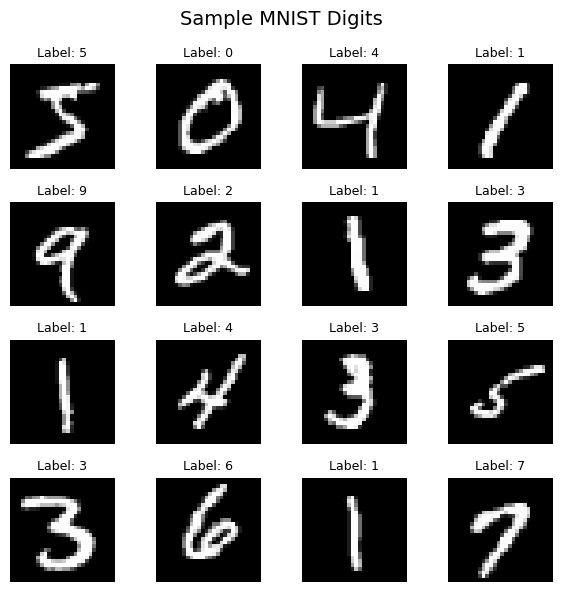

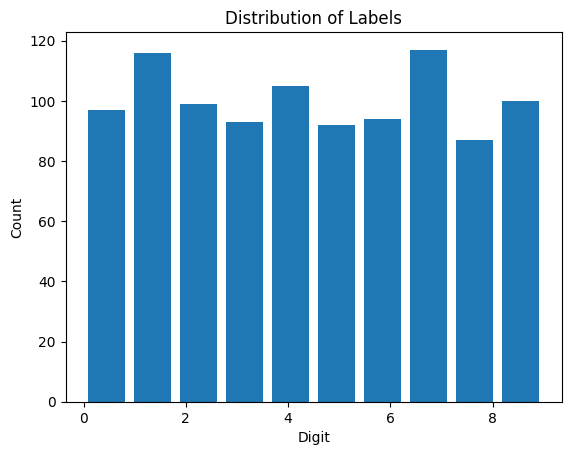

In [2]:
# Load a subset of MNIST to start
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
x_full = mnist.data[:num_samples] / 255.0  # Scale pixel values to [0,1]
x_full = x_full.astype('float32')
y_full = mnist.target[:num_samples].astype(int)

# Show a grid of 16 sample images
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_full[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {y_full[i]}", fontsize=9)
    ax.axis('off')
fig.suptitle("Sample MNIST Digits", fontsize=14)
plt.tight_layout()

# Look at the distribution of labels
plt.figure()
plt.hist(y_full, bins=10, rwidth=0.8)
plt.title("Distribution of Labels")
plt.xlabel("Digit")
plt.ylabel("Count");

### Understanding Flattening

To use these images in our model, we need to "flatten" each 28x28 grid into a single vector of 784 numbers:

Shape after flattening: (784,)


Text(0, 0.5, 'Pixel value')

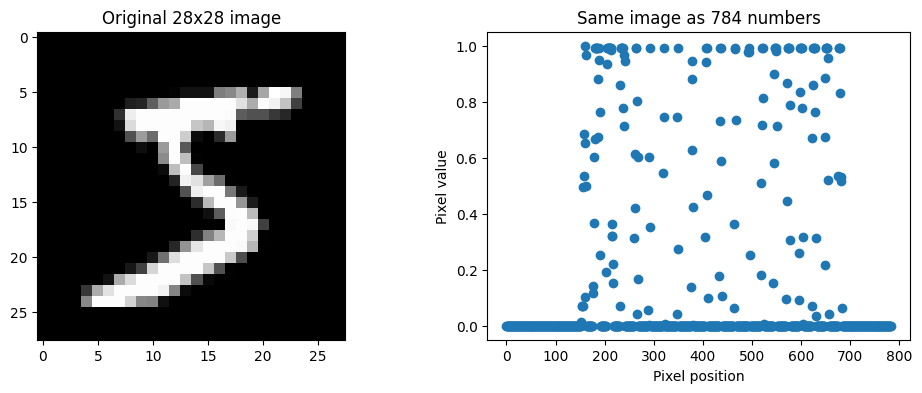

In [3]:
# Demonstrate flattening on one image
single_image = x_full[0].reshape(28, 28)
flat_image = single_image.reshape(-1)  # -1 means "figure out this dimension"
print("Shape after flattening:", flat_image.shape)

# Visualize how flattening works
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.imshow(single_image, cmap='gray')
ax1.set_title("Original 28x28 image")
ax2.scatter(np.arange(784), flat_image)
ax2.set_title("Same image as 784 numbers")
ax2.set_xlabel("Pixel position")
ax2.set_ylabel("Pixel value")

Our dataset `x_full` was already flattened: each row is one flattened image:

In [4]:
print("Full dataset shape:", x_full.shape)
print("Number of training examples:", x_full.shape[0])
print("Number of features per example:", x_full.shape[1])

Full dataset shape: (1000, 784)
Number of training examples: 1000
Number of features per example: 784


### Setting Up Data Loaders

We split the data into training and validation sets and create PyTorch `DataLoader` objects.

**Why batch?** Processing all images at once may not fit in memory. Batches also give us *stochastic* gradient updates, which can help training.

**Why shuffle?** If the data is sorted by label, each batch would contain only one digit. Shuffling ensures each batch is a representative mix.

In [5]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_full, y_full, test_size=0.2, random_state=42)

# Create DataLoader objects
train_data = TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
val_data = TensorDataset(torch.tensor(x_val), torch.tensor(y_val))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

## Train an MLP to Classify MNIST

We'll build a two-layer MLP: input (784) → hidden (128 with ReLU) → output (10 logits).

Before writing the code, **estimate**: what accuracy should a randomly-initialized model get on 10-class classification? What cross-entropy loss would that correspond to?

### Shape checkpoint

Before running the training code, make sure you can answer:
- If the input batch has shape `(32, 784)` and `linear_1` maps 784 → 128, what is the shape after `linear_1`?
- After ReLU, what is the shape?
- After `linear_2` (128 → 10), what is the shape? Why 10?

*1. (32, 128).<br/>
2. (32, 128).  Relu is an activation function only and does nothing to change the shape.<br/>
3. (32, 10). The shape is 10 because there are 10 classes, with each class representing a digit.*

Epoch   0: train_loss=1.630, val_loss=0.811, train_acc=45.6%, val_acc=75.5%
Epoch  10: train_loss=0.019, val_loss=0.495, train_acc=100.0%, val_acc=90.0%
Epoch  20: train_loss=0.006, val_loss=0.554, train_acc=100.0%, val_acc=89.0%
Epoch  30: train_loss=0.003, val_loss=0.592, train_acc=100.0%, val_acc=89.5%
Epoch  40: train_loss=0.002, val_loss=0.616, train_acc=100.0%, val_acc=89.5%
Epoch  50: train_loss=0.002, val_loss=0.631, train_acc=100.0%, val_acc=89.5%
Epoch  60: train_loss=0.001, val_loss=0.646, train_acc=100.0%, val_acc=89.5%
Epoch  70: train_loss=0.001, val_loss=0.660, train_acc=100.0%, val_acc=89.5%
Epoch  80: train_loss=0.001, val_loss=0.670, train_acc=100.0%, val_acc=89.5%
Epoch  90: train_loss=0.001, val_loss=0.680, train_acc=100.0%, val_acc=89.5%
Epoch  99: train_loss=0.001, val_loss=0.687, train_acc=100.0%, val_acc=89.5%


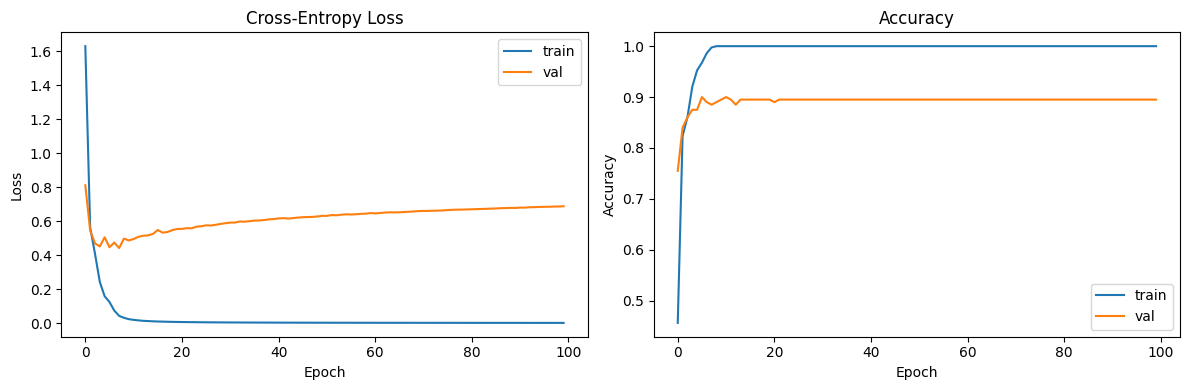

In [7]:
# Define the model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.linear_1 = nn.Linear(in_features=784, out_features=128, bias=True)
        self.linear_2 = nn.Linear(in_features=128, out_features=10, bias=True)

    def forward(self, x):
        z1 = self.linear_1(x)
        a1 = F.relu(z1)  # equivalently: z1.clamp(min=0) or torch.max(z1, torch.tensor(0.0))
        logits = self.linear_2(a1)
        return logits

# Instantiate the model
input_size = 784
hidden_size = 128
num_classes = 10

model = MLP(input_size, hidden_size, num_classes)
learning_rate = 0.5

# Train the model
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(max_iter):
    # --- Training ---
    train_loss = 0.
    train_correct = 0
    train_total = 0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Forward pass
        logits = model(x_batch)
        # Compute the loss (remember that F.cross_entropy does the softmax internally)
        loss = F.cross_entropy(logits, y_batch)
        train_loss += loss.item()

        # Track accuracy
        preds = logits.argmax(dim=1)
        train_correct += (preds == y_batch).sum().item()
        train_total += len(y_batch)

        # Backward pass
        # Clear old gradients
        model.zero_grad()
        # Compute the gradients
        loss.backward()
        # Update the weights
        for param in model.parameters():
            param.data -= learning_rate * param.grad

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_correct / train_total)

    # --- Validation ---
    with torch.no_grad():
        val_loss = 0.
        val_correct = 0
        val_total = 0
        for x_val_batch, y_val_batch in val_loader:
            logits = model(x_val_batch)
            val_loss += F.cross_entropy(logits, y_val_batch)
            preds = logits.argmax(dim=1)
            val_correct += (preds == y_val_batch).sum().item()
            val_total += len(y_val_batch)
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_correct / val_total)

    if epoch % 10 == 0 or epoch == max_iter - 1:
        print(f"Epoch {epoch:3d}: train_loss={train_loss:.3f}, val_loss={val_loss:.3f}, "
              f"train_acc={train_accuracies[-1]:.1%}, val_acc={val_accuracies[-1]:.1%}")

# Plot loss and accuracy side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(train_losses, label='train')
ax1.plot(val_losses, label='val')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.set_title('Cross-Entropy Loss')
ax2.plot(train_accuracies, label='train')
ax2.plot(val_accuracies, label='val')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy'); ax2.legend(); ax2.set_title('Accuracy')
plt.tight_layout()

**Make sure you can explain** what each of these lines does in the training loop:
1. `logits = model(x_batch)` — forward pass
2. `loss = F.cross_entropy(logits, y_batch)` — compute loss (includes softmax internally)
3. `model.zero_grad()` — clear gradients from previous step
4. `loss.backward()` — compute gradients via backpropagation
5. `param.data -= learning_rate * param.grad` — update weights (SGD step)

## Analyzing the Trained Model

Now that we've trained the model, let's look at what it learned:
1. Predictions on sample images
2. Where it gets confused (confusion matrix)
3. Its most confident mistakes
4. The learned weights

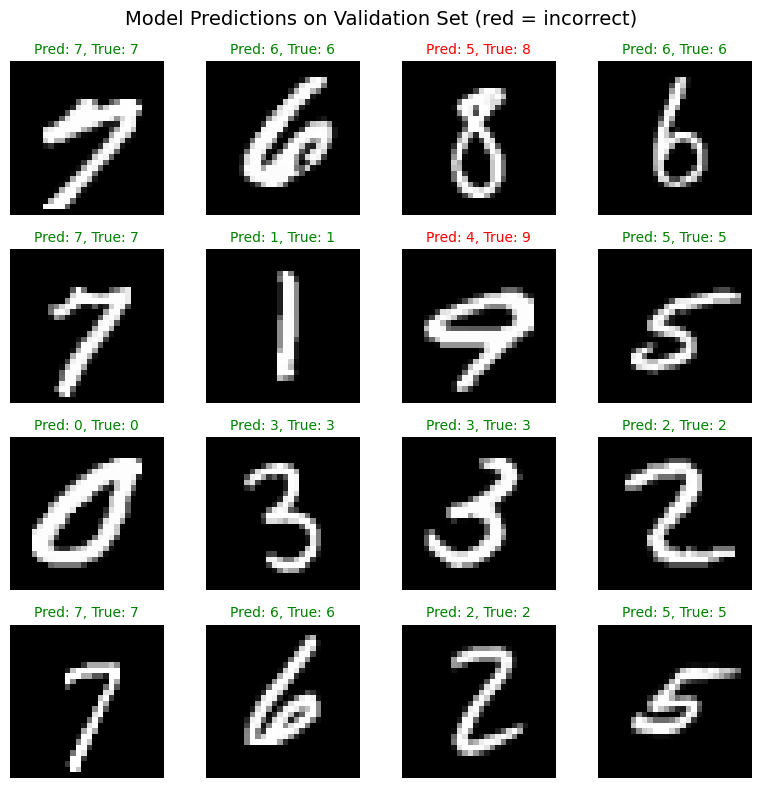

In [ ]:
# Show predictions on validation images
x_val_tensor = torch.tensor(x_val)
with torch.no_grad():
    val_logits = model(x_val_tensor)
    val_preds = val_logits.argmax(dim=1)
    val_probs = val_logits.softmax(dim=-1)

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_val[i].reshape(28, 28), cmap='gray')
    pred = val_preds[i].item()
    actual = y_val[i]
    color = 'green' if pred == actual else 'red'
    ax.set_title(f"Pred: {pred}, True: {actual}", color=color, fontsize=10)
    ax.axis('off')
fig.suptitle("Model Predictions on Validation Set (red = incorrect)", fontsize=14)
plt.tight_layout()

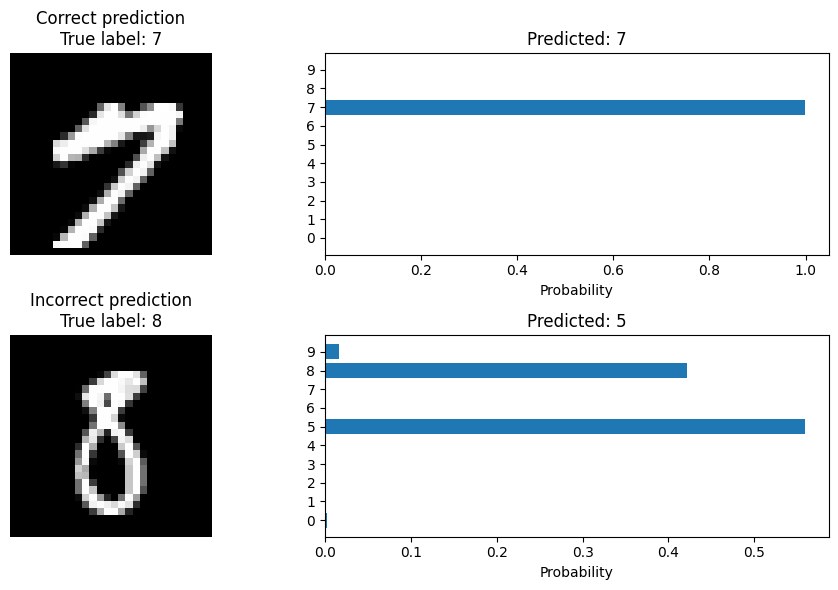

In [ ]:
# Show softmax probabilities for one correct and one incorrect prediction
correct_idx = None
incorrect_idx = None
for i in range(len(val_preds)):
    pred = val_preds[i].item()
    if pred == y_val[i] and correct_idx is None:
        correct_idx = i
    if pred != y_val[i] and incorrect_idx is None:
        incorrect_idx = i
    if correct_idx is not None and incorrect_idx is not None:
        break

indices_to_show = [i for i in [correct_idx, incorrect_idx] if i is not None]
titles = ["Correct prediction", "Incorrect prediction"]

fig, axes = plt.subplots(len(indices_to_show), 2, figsize=(10, 3 * len(indices_to_show)))
if len(indices_to_show) == 1:
    axes = axes.reshape(1, -1)

for row, idx in enumerate(indices_to_show):
    axes[row, 0].imshow(x_val[idx].reshape(28, 28), cmap='gray')
    axes[row, 0].set_title(f"{titles[row]}\nTrue label: {y_val[idx]}")
    axes[row, 0].axis('off')
    axes[row, 1].barh(range(10), val_probs[idx].numpy())
    axes[row, 1].set_yticks(range(10))
    axes[row, 1].set_xlabel("Probability")
    axes[row, 1].set_title(f"Predicted: {val_preds[idx].item()}")
plt.tight_layout()

### Confusion Matrix

Which digits does the model confuse with each other?

Overall validation accuracy: 89.5%


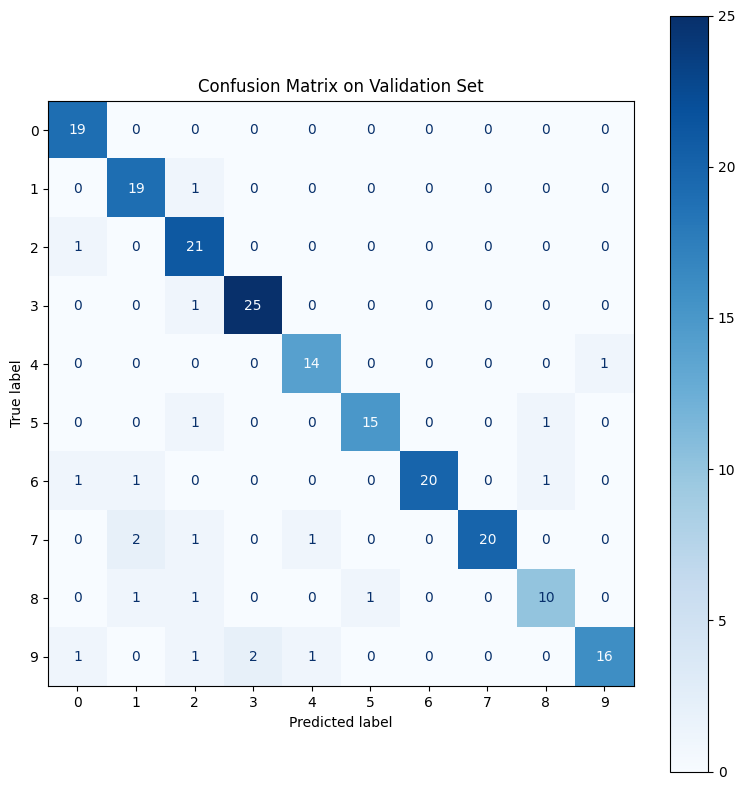

In [ ]:
cm = confusion_matrix(y_val, val_preds.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues')
ax.set_title("Confusion Matrix on Validation Set")
plt.tight_layout()

val_acc = (val_preds.numpy() == y_val).mean()
print(f"Overall validation accuracy: {val_acc:.1%}")

### Most Confident Mistakes

These are the images where the model was *most certain* about the wrong answer. These are often the most informative errors to examine.

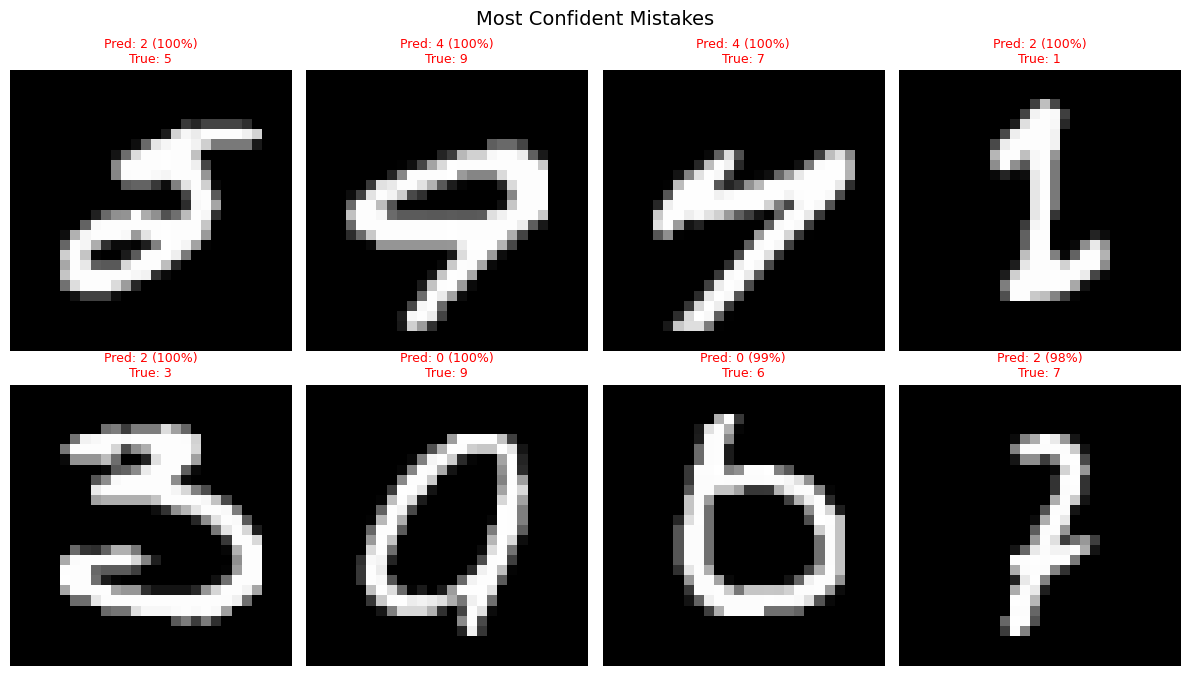

In [ ]:
# Find the most confidently wrong predictions
wrong_mask = val_preds.numpy() != y_val
if wrong_mask.sum() > 0:
    wrong_indices = np.where(wrong_mask)[0]
    # Confidence = max probability for wrong predictions
    wrong_confidences = val_probs[wrong_indices].max(dim=1).values.numpy()
    # Sort by confidence (most confident first)
    sorted_order = np.argsort(-wrong_confidences)

    n_show = min(8, len(sorted_order))
    fig, axes = plt.subplots(2, min(4, n_show), figsize=(3 * min(4, n_show), 7))
    if n_show <= 4:
        axes = axes.reshape(1, -1) if n_show > 1 else np.array([[axes]])
    for i in range(n_show):
        row, col = divmod(i, min(4, n_show))
        idx = wrong_indices[sorted_order[i]]
        ax = axes[row, col] if n_show > 4 else axes[0, i]
        ax.imshow(x_val[idx].reshape(28, 28), cmap='gray')
        conf = wrong_confidences[sorted_order[i]]
        ax.set_title(f"Pred: {val_preds[idx].item()} ({conf:.0%})\nTrue: {y_val[idx]}", color='red', fontsize=9)
        ax.axis('off')
    fig.suptitle("Most Confident Mistakes", fontsize=14)
    plt.tight_layout()
else:
    print("No mistakes found!")

# Adversarial Examples

Our model is confident on most images — but how fragil*e is that confidence? An **adversarial example** is an image with a tiny, carefully-chosen perturbation that fools the model. We'll use the simplest attack: FGSM (Fast Gradient Sign Method), which nudges each pixel in the direction that *increases* the loss.



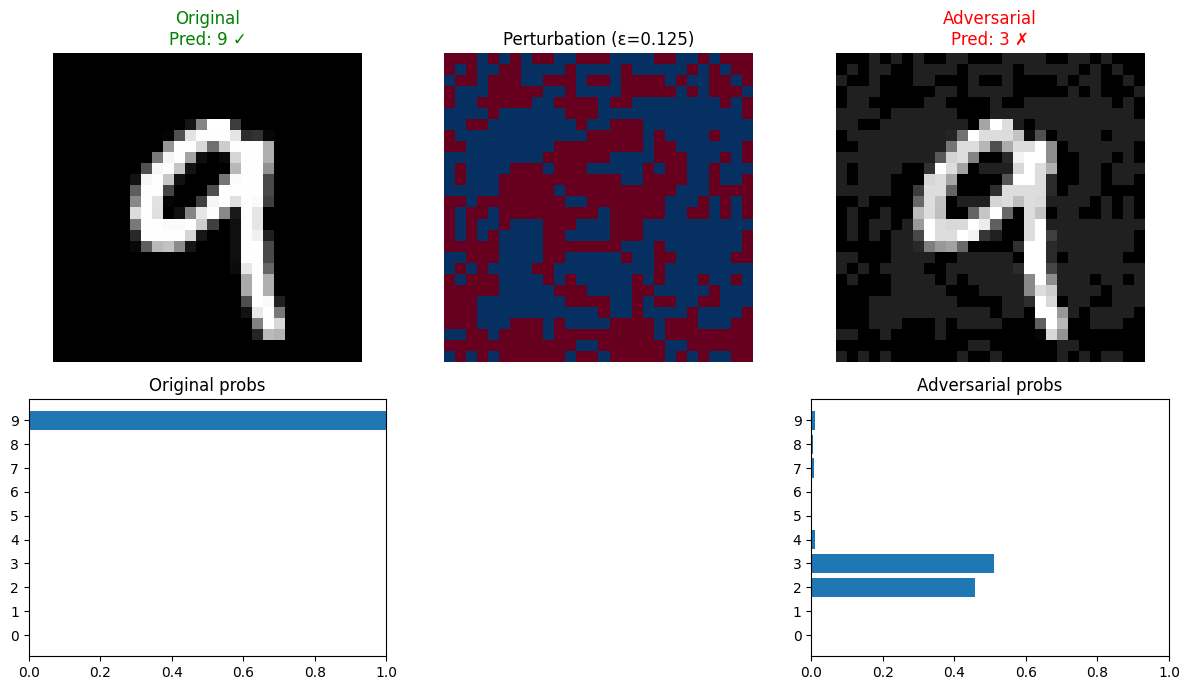

In [ ]:
# Pick a correctly-classified validation image at random
np.random.seed(0)  # for reproducibility
while True:
    target_idx = np.random.randint(0, len(val_preds))
    if val_preds[target_idx].item() == y_val[target_idx]:
        break

# We need gradients w.r.t. the input image
x_adv = torch.tensor(x_val[target_idx:target_idx+1], requires_grad=True)
true_label = torch.tensor([y_val[target_idx]])

# Forward pass and compute loss
logits = model(x_adv)
loss = F.cross_entropy(logits, true_label)
loss.backward()

# FGSM: perturb in the direction of the gradient's sign
epsilon = 0.125  # perturbation magnitude — try making this smaller!
perturbation = epsilon * x_adv.grad.sign()
x_adversarial = (x_adv + perturbation).clamp(0, 1).detach()

# Classify the adversarial image
with torch.no_grad():
    adv_logits = model(x_adversarial)
    adv_pred = adv_logits.argmax(dim=1).item()
    adv_probs = adv_logits.softmax(dim=-1)[0]
    orig_probs = logits.softmax(dim=-1)[0].detach()

# Visualize: original | perturbation | adversarial
fig, axes = plt.subplots(2, 3, figsize=(12, 7),
                          gridspec_kw={'height_ratios': [1.2, 1]})

# Top row: images
axes[0, 0].imshow(x_val[target_idx].reshape(28, 28), cmap='gray')
axes[0, 0].set_title(f"Original\nPred: {val_preds[target_idx].item()} ✓", color='green')
axes[0, 0].axis('off')

axes[0, 1].imshow(perturbation[0].reshape(28, 28).numpy(), cmap='RdBu', vmin=-epsilon, vmax=epsilon)
axes[0, 1].set_title(f"Perturbation (ε={epsilon})")
axes[0, 1].axis('off')

axes[0, 2].imshow(x_adversarial[0].reshape(28, 28).numpy(), cmap='gray')
color = 'red' if adv_pred != y_val[target_idx] else 'green'
axes[0, 2].set_title(f"Adversarial\nPred: {adv_pred} {'✗' if adv_pred != y_val[target_idx] else '✓'}", color=color)
axes[0, 2].axis('off')

# Bottom row: probability bar charts
for col, (probs, title) in enumerate([(orig_probs, "Original probs"), (None, ""), (adv_probs, "Adversarial probs")]):
    if probs is None:
        axes[1, col].axis('off')
        continue
    axes[1, col].barh(range(10), probs.numpy())
    axes[1, col].set_yticks(range(10))
    axes[1, col].set_xlim(0, 1)
    axes[1, col].set_title(title)

plt.tight_layout()

The perturbation is almost invisible to us, but it completely changes the model's prediction. This reveals something important: the model's decision boundaries in 784-dimensional space don't align with what humans consider meaningful differences.

Try reducing epsilon. What's the smallest perturbation that still fools the model? What does this tell you about the model's robustness?

*your answer here*

### Visualizing Learned Weights

For the first layer (`linear_1`), each of the 128 output neurons has 784 weights -- one per input pixel. We can reshape these weight vectors back to 28x28 images to see what patterns each neuron has learned to detect.

> **Note**: In a multi-layer network, these weight images are harder to interpret than in a single-layer network (like logistic regression), because each hidden neuron only contributes *partially* to the final classification. Still, we can often see that neurons specialize in detecting particular strokes or patterns.

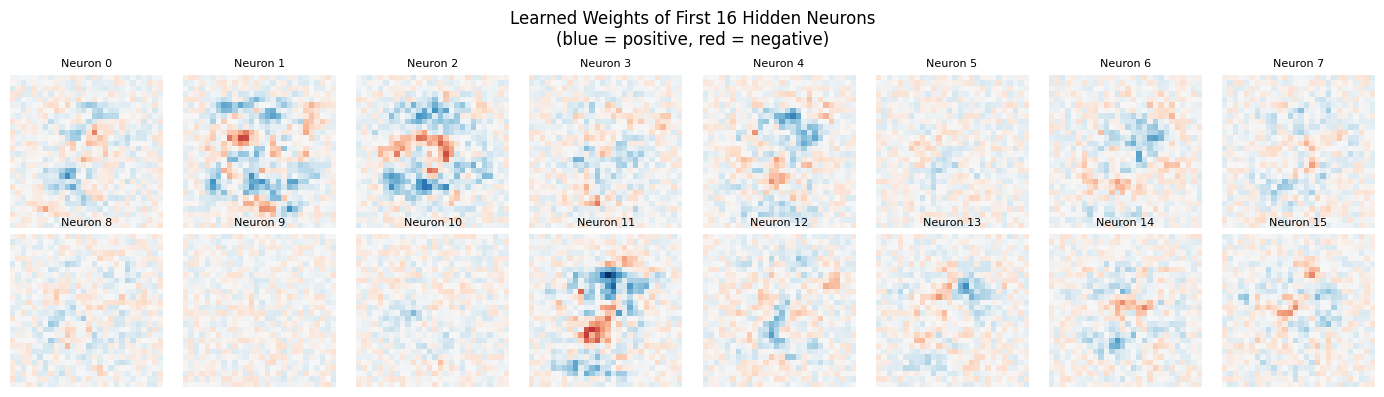

In [ ]:
# Visualize the first 16 hidden neuron weights as 28x28 images
weight_images = model.linear_1.weight.data[:16].reshape(16, 28, 28)
vmax = weight_images.abs().max()
fig, axes = plt.subplots(2, 8, figsize=(14, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(weight_images[i].numpy(), cmap='RdBu', vmin=-vmax, vmax=vmax)
    ax.set_title(f"Neuron {i}", fontsize=8)
    ax.axis('off')
fig.suptitle("Learned Weights of First 16 Hidden Neurons\n(blue = positive, red = negative)", fontsize=12)
plt.tight_layout()

Unlike a single-layer classifier (where each weight image directly corresponds to one digit class), these hidden neurons learn *features* -- stroke patterns, edges, or partial digit shapes. The second layer (`linear_2`) then combines these features to make the final classification.

If you want to see weight images that look more like digits, try changing the model to a single layer (remove the hidden layer and ReLU) and retrain.

## Reflection Questions

**Q1**: In the training loop, if `x_batch` has shape `(32, 784)`, trace the shapes through the network:
- After `linear_1`: ?
- After ReLU: ?
- After `linear_2` (logits): ?

Explain *why* the logits have the shape they do.

*your answer here*

**Q2**: Before training (random weights), the cross-entropy loss was approximately 2.3. Why? What is the theoretical value for a 10-class classifier that assigns equal probability to all classes?

(Hint: what probability does each class get if the model is maximally uncertain?)

*your answer here*

In [ ]:
# Hint:
np.log(10)

np.float64(2.302585092994046)

**Q3**: Go back and try different learning rates. Find:
- A learning rate that is **too high** (loss diverges or oscillates wildly)
- A learning rate that is **too low** (loss barely decreases in 100 epochs)
- A learning rate that works **well**

For each, describe what the loss curve looks like and what the final accuracy is.

*your answer here*

**Q4**: Look at the weight visualizations above. Why might the hidden neurons learn patterns that look like strokes or edges? What limitation does having just a single hidden layer impose on what the network can represent?

*your answer here*

## Next Steps

- **Data augmentation**: See the supplemental notebook (`u06s2-mnist-torch-augmentation`) for how shifting images during training improves robustness.
- **Better optimizers**: Try replacing the manual SGD step with `torch.optim.SGD` or `torch.optim.Adam`.
- **More data**: Increase `num_samples` to 10000 or use the full dataset and observe how accuracy changes.